In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'biodeg_V25', 
                'credit_A1', 'sick_referral_source_other', 'vote_immigration', 'ads_local', 'churn_voice_mail_plan']

noise_types = ['random', 'flip', 'bias', 'balanced_bias']

nr = [0.1, 0.2, 0.3, 0.4, 0.5]

In [3]:
type_names = {
    'random': 'Random',
    'flip': 'Flip',
    'bias': 'Positive Bias',
    'balanced_bias': 'Balanced Bias'
}

metric_names = {
    'accuracy': 'Accuracy',
    'roc_auc': 'AUC',
    'auc_difference': 'AUC Difference',
    'equal_opportunity_difference': 'Equal Opportunity Difference',
    'predictive_equality_difference': 'Predictive Equality Difference',
    'demographic_parity_difference': 'Demographic Parity Difference',
    'equalized_odds_difference': 'Equalized Odds Difference'
}


In [4]:
colors = {'PL':'tab:blue', 
          'STC':'tab:orange', 
          'CC':'tab:green', 
          'HLNC':'tab:red', 
          'OBNC':'tab:purple', 
          'BE':'tab:brown'}

In [5]:
pred_metrics = ['accuracy', 'roc_auc']

fair_metrics = [
        'auc_difference',
        'equal_opportunity_difference', 
        'predictive_equality_difference',
        'demographic_parity_difference',
        'equalized_odds_difference']

metrics = pred_metrics + fair_metrics

In [6]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for exp in experiments:
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv').fillna(0)

In [7]:
def show_corrected_test_performance(noise_type, metric, algorithms, experiments, runs, thresh=0.5):
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(3, 2, sharey=True, sharex=True)

    metric_name = f'{metric}_{thresh}' if metric not in ['roc_auc', 'auc_difference'] else metric

    for i in range(6):
        row = i // 2
        col = i % 2
        alg = algorithms[i]

        results = {noise_rate: [] for noise_rate in nr}
        results_original = {noise_rate: [] for noise_rate in nr}

        for exp in experiments:
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'corrected']
            for noise_rate in nr:
                results[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric_name}'].values[0])
            
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'original']
            for noise_rate in nr:
                results_original[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric_name}'].values[0])
            
        axs[row, col].plot(nr, [np.mean(results_original[noise_rate]) for noise_rate in nr], label='original test set', color='black', linestyle='--', linewidth=2)
        axs[row, col].errorbar(nr, [np.mean(results[noise_rate]) for noise_rate in nr], yerr=[np.std(results[noise_rate]) for noise_rate in nr] , label=f'{alg} corrected test set', color=colors[alg])

        if row == 2:
            axs[row, col].set_xlabel('Noise rate')
        if col == 0:
            axs[row, col].set_ylabel(metric_names[metric])

        axs[row, col].legend()
        axs[row, col].set_title(f'Train set: {alg} corrected')

    plt.subplots_adjust(wspace=0.07, hspace=0.2)
    plt.suptitle(f'{type_names[noise_type]} noise', fontsize=16, y=0.95)
    plt.show()

# Random noise

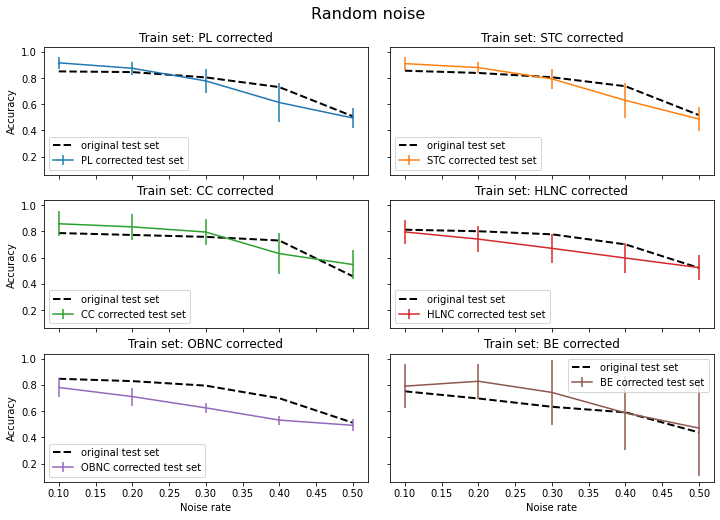

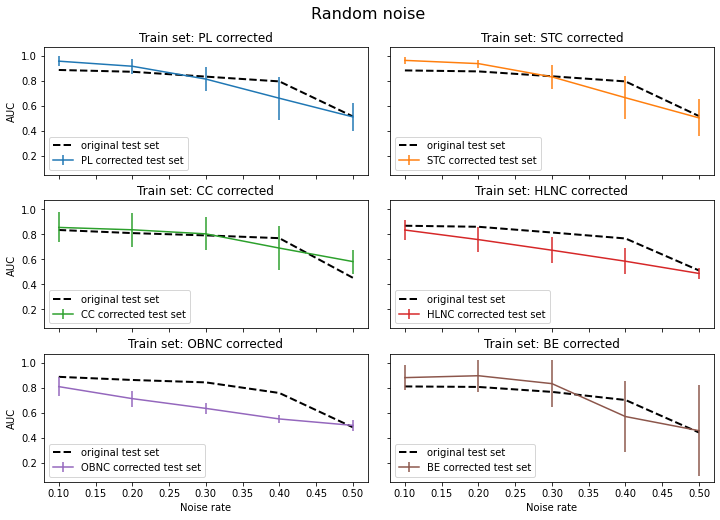

In [8]:
for metric in pred_metrics:
    show_corrected_test_performance('random', metric, algorithms, experiments, runs)

# Group-dependant noise

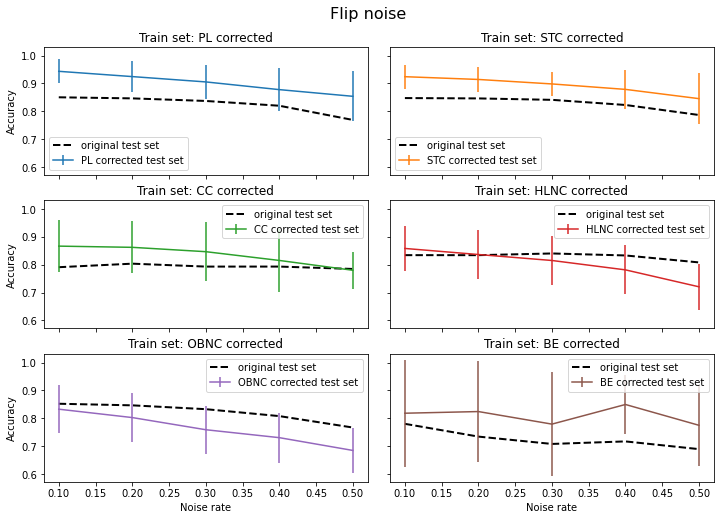

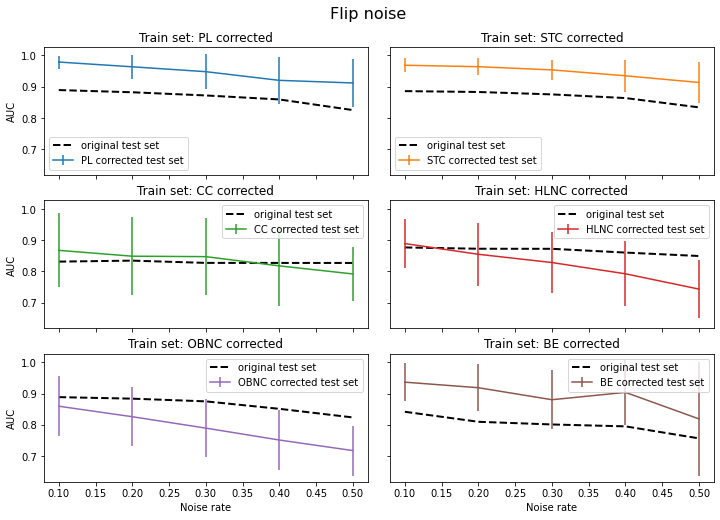

In [9]:
for metric in pred_metrics:
    show_corrected_test_performance('flip', metric, algorithms, experiments, runs)

# Positive bias noise

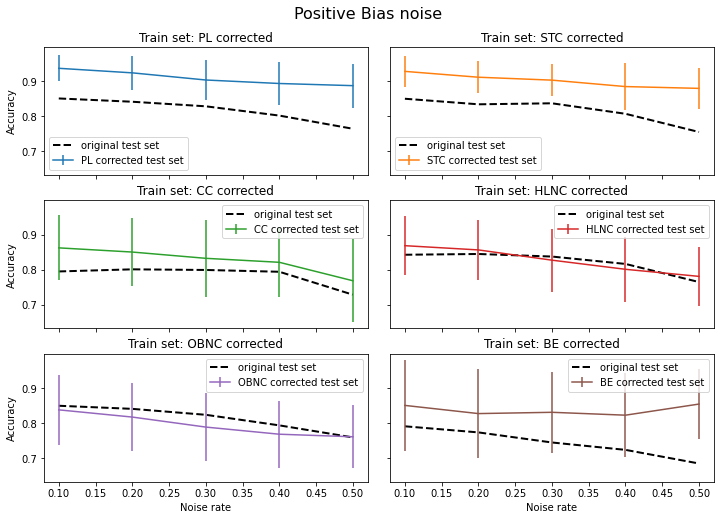

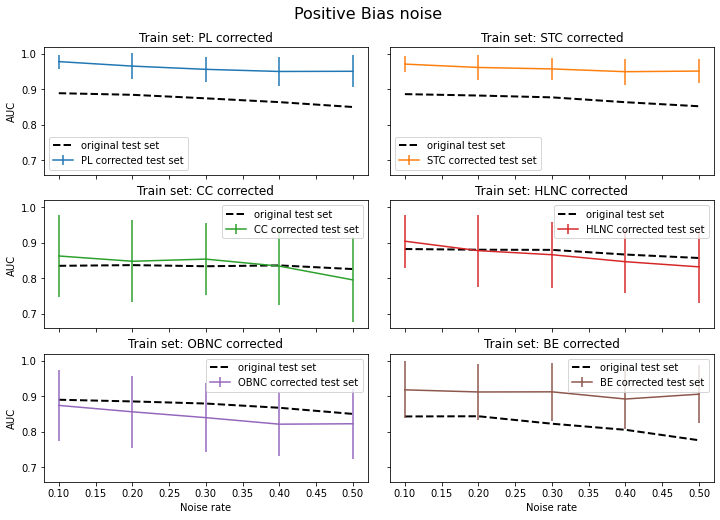

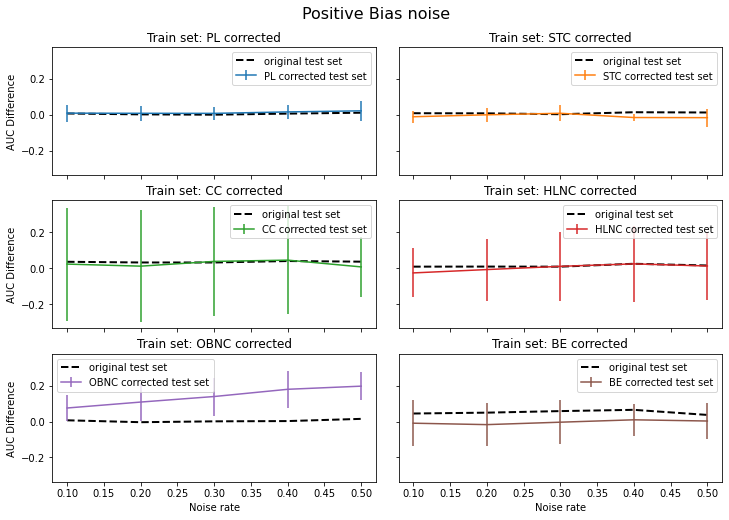

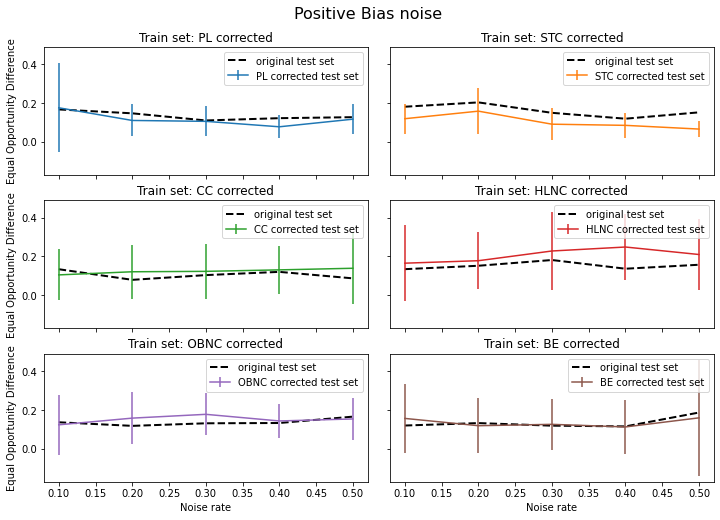

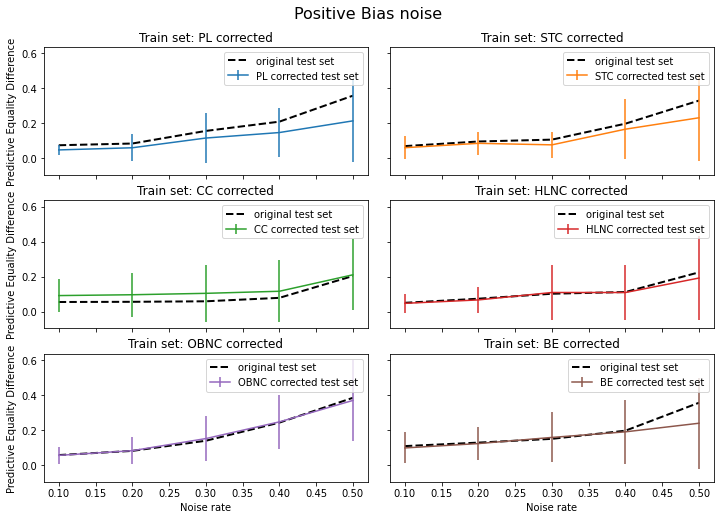

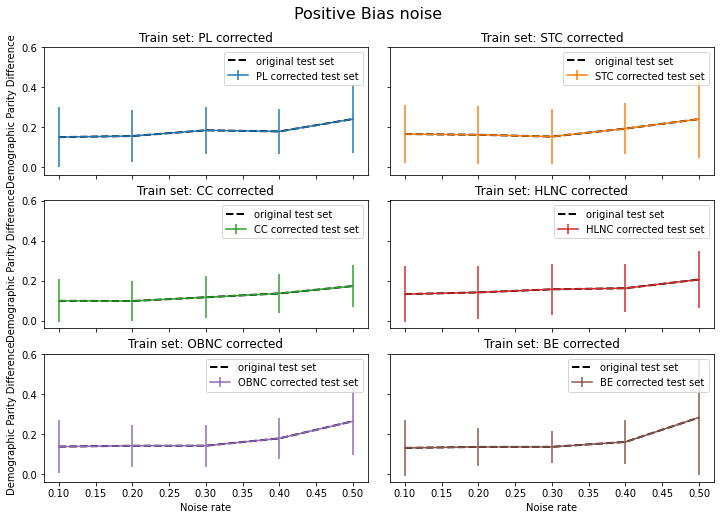

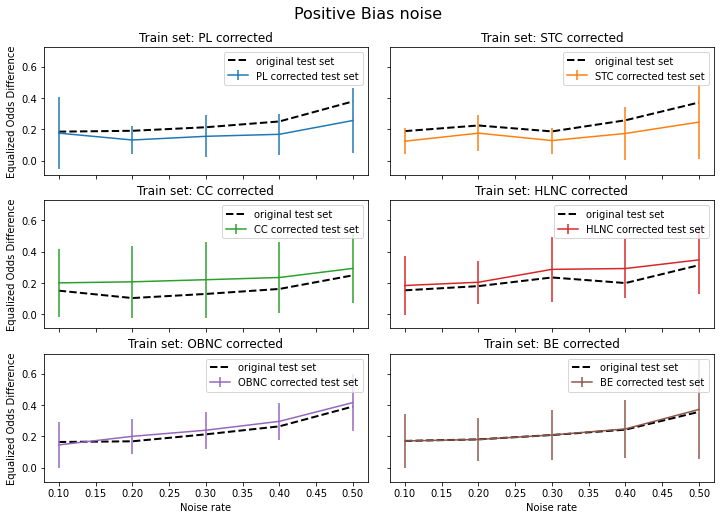

In [10]:
for metric in metrics:
    show_corrected_test_performance('bias', metric, algorithms, experiments, runs)

# Balanced bias noise

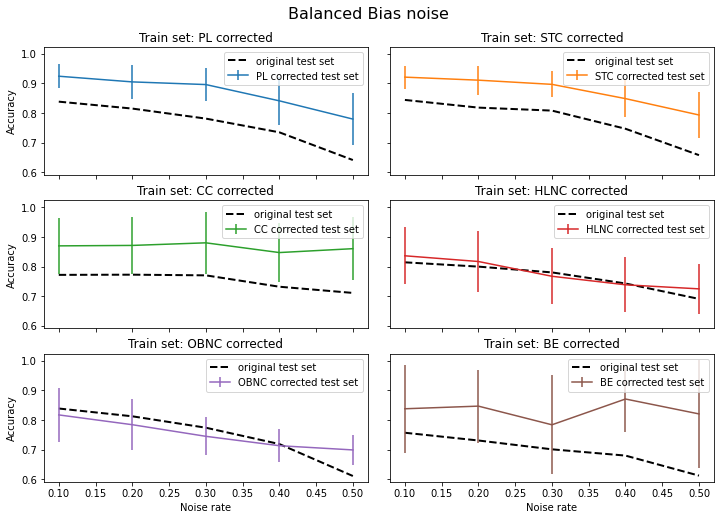

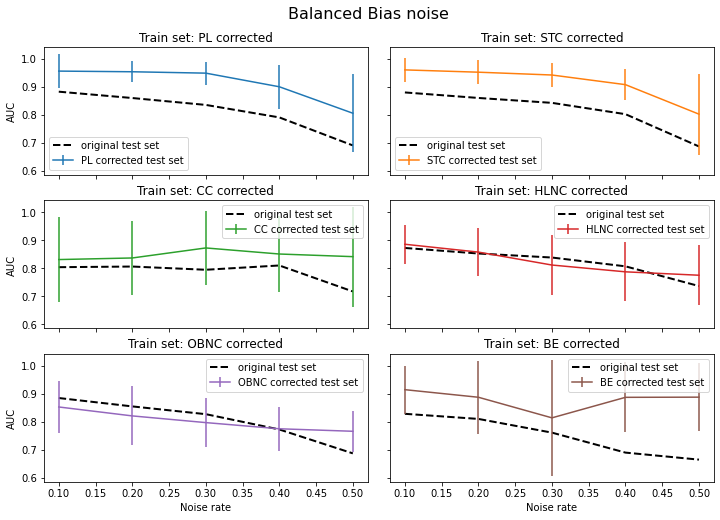

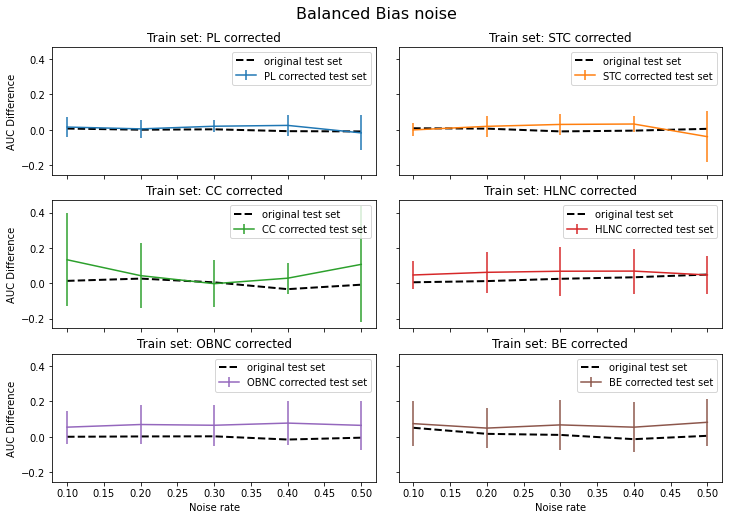

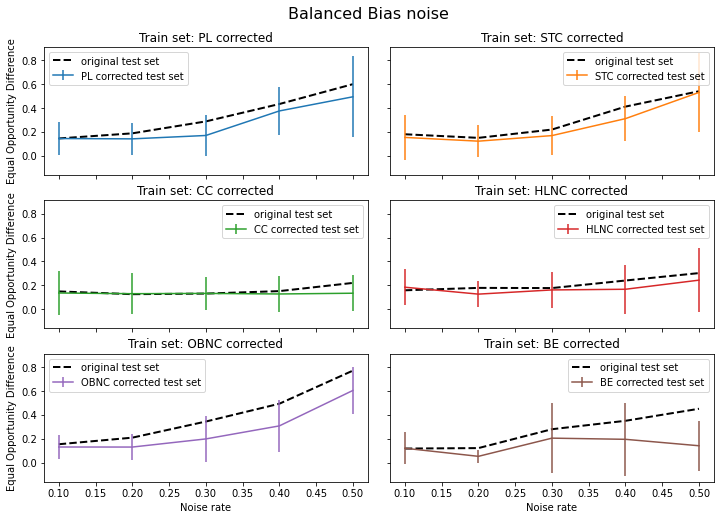

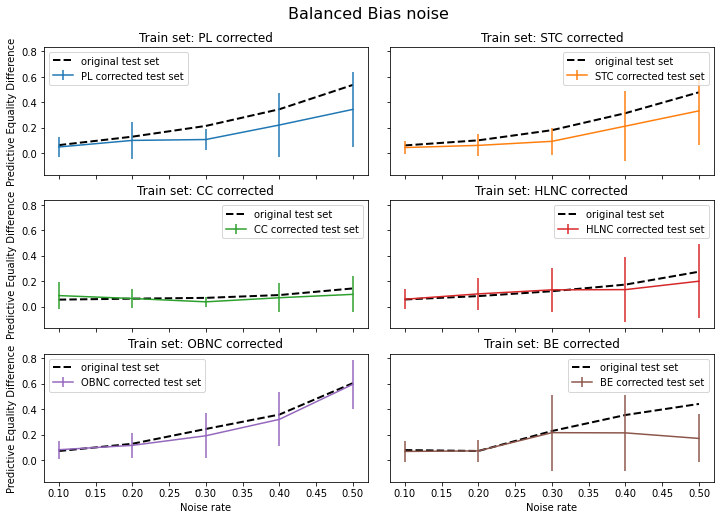

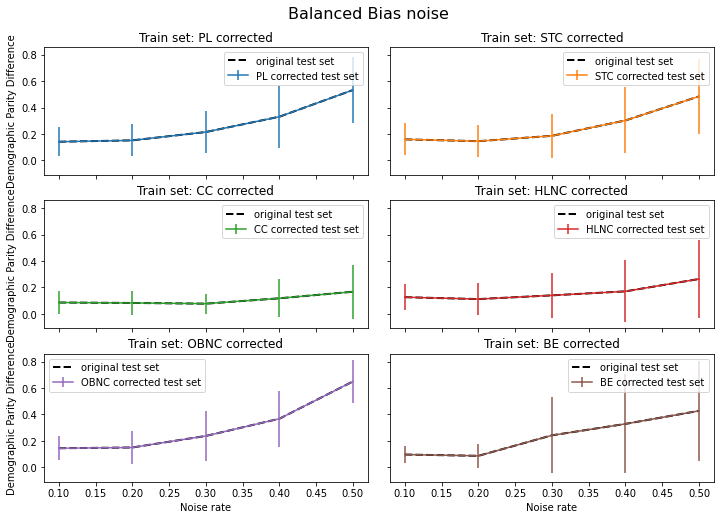

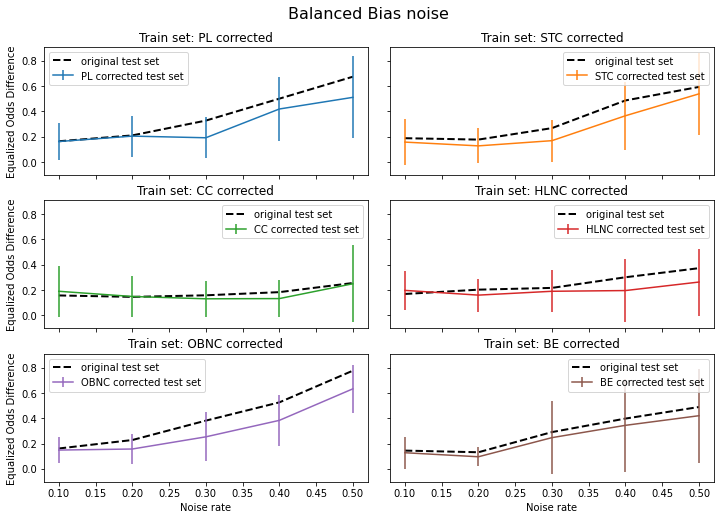

In [11]:
for metric in metrics:
    show_corrected_test_performance('balanced_bias', metric, algorithms, experiments, runs)